# SMOG data prep

* Główny Inspektorat Ochrony Środowiska (GIO) dane archiwalne https://powietrze.gios.gov.pl/pjp/archives
* Dane publiczne IMGW-PIB https://danepubliczne.imgw.pl/
* ROCZNA OCENA JAKOŚCI POWIETRZA W WOJEWÓDZTWIE MAZOWIECKIM RAPORT WOJEWÓDZKI ZA ROK 2018 http://powietrze.gios.gov.pl/pjp/documents/download/103120

Let's start with imports of needed modules:

In [1]:
import numpy as np
import pandas as pd
import os
import requests
import re
import shutil
import sys
import zipfile

Removal of previous daya and preparation of new folders

In [2]:
shutil.rmtree('data',ignore_errors=True)
os.mkdir('data')
os.mkdir('data/gios')
os.mkdir('data/imgw')

Some handy function to download files from internet (wget reinvented:)

In [3]:
# https://sumit-ghosh.com/articles/python-download-progress-bar/
def download(url, folder,filename=None):

    response = requests.get(url, stream=True)
    
    # https://stackoverflow.com/questions/31804799/how-to-get-pdf-filename-with-python-requests
    if filename is None:
        if 'content-disposition' in response.headers:
            d = response.headers['content-disposition']
            filename = re.findall("filename=(.+)", d)[0]
        else:
            filename = url.split('/')[-1]
    total = response.headers.get('content-length')

    full_file_path = os.path.join(folder,filename)
    
    with open(full_file_path, 'wb') as f:
        if total is None:
            f.write(response.content)
        else:
            downloaded = 0
            total = int(total)
            sys.stdout.write('{} saved to {} \n'.format(url,full_file_path))
            for data in response.iter_content(chunk_size=max(int(total/1000), 1024*1024)):
                downloaded += len(data)
                f.write(data)
                done = int(100*downloaded/total)
                sys.stdout.write('\r[{}{}] {} %'.format('█' * (done//2), '.' * (50-done//2),done))
                sys.stdout.flush()
    sys.stdout.write('\n')
    
    return full_file_path

# Global params

In [4]:
download_years=range(2017,2019)

# GIOS

In [5]:
gios_url =  'http://powietrze.gios.gov.pl/pjp/archives/downloadFile/'
gios_meta_file = '283'
gios_codes_file = '102'
gios_year2file = {2016:"242",2017:"262",2018:"282"}
group_by = '24g' # 1g,24g

In [6]:
gios_meta_local_file = download('/'.join([gios_url,gios_meta_file]),'data/gios')
gios_codes_local_file = download('/'.join([gios_url,gios_codes_file]),'data/gios')

http://powietrze.gios.gov.pl/pjp/archives/downloadFile//283 saved to data/gios/"Metadane - stacje i stanowiska pomiarowe.xlsx" 
[██████████████████████████████████████████████████] 100 %
http://powietrze.gios.gov.pl/pjp/archives/downloadFile//102 saved to data/gios/"Kopia Kody_stacji_pomiarowych.xlsx" 
[██████████████████████████████████████████████████] 100 %


In [7]:
# year data
gios_data_local_files = []
for year in download_years:
    local_file = download( '/'.join([gios_url,gios_year2file[year]]),'data/gios')
    with zipfile.ZipFile(local_file, 'r') as z:
       gios_data_local_files+=z.namelist()
       z.extractall('data/gios')

http://powietrze.gios.gov.pl/pjp/archives/downloadFile//262 saved to data/gios/"2017.zip" 
[██████████████████████████████████████████████████] 100 %
http://powietrze.gios.gov.pl/pjp/archives/downloadFile//282 saved to data/gios/"Wyniki pomiarów z 2018 roku.ZIP" 
[██████████████████████████████████████████████████] 100 %


In [8]:
print(gios_data_local_files)

['2017_SO2_24g.xlsx', '2017_SO2_1g.xlsx', '2017_PM25_24g.xlsx', '2017_PM25_1g.xlsx', '2017_PM10_24g.xlsx', '2017_PM10_1g.xlsx', '2017_Pb(PM10)_24g.xlsx', '2017_O3_1g.xlsx', '2017_NOx_1g.xlsx', '2017_NO2_24g.xlsx', '2017_NO2_1g.xlsx', '2017_Ni(PM10)_24g.xlsx', '2017_IP(PM10)_24g.xlsx', '2017_Hg(TGM)_24g.xlsx', '2017_Hg(TGM)_1g.xlsx', '2017_formaldehyd_24g.xlsx', '2017_DBahA(PM10)_24g.xlsx', '2017_CO_1g.xlsx', '2017_Cd(PM10)_24g.xlsx', '2017_C6H6_24g.xlsx', '2017_C6H6_1g.xlsx', '2017_BkF(PM10)_24g.xlsx', '2017_BjF(PM10)_24g.xlsx', '2017_BbF(PM10)_24g.xlsx', '2017_BaP(PM10)_24g.xlsx', '2017_BaA(PM10)_24g.xlsx', '2017_As(PM10)_24g.xlsx', '2017_Jony_PM2_5_24g.xlsx', '2017_Depozycja.xlsx', '2018_As(PM10)_24g.xlsx', '2018_BaA(PM10)_24g.xlsx', '2018_BaP(PM10)_24g.xlsx', '2018_BbF(PM10)_24g.xlsx', '2018_BjF(PM10)_24g.xlsx', '2018_BkF(PM10)_24g.xlsx', '2018_C6H6_1g.xlsx', '2018_C6H6_24g.xlsx', '2018_Cd(PM10)_24g.xlsx', '2018_CO_1g.xlsx', '2018_DBahA(PM10)_24g.xlsx', '2018_Depozycja.xlsx', '2018_

In [9]:
df=pd.read_excel(os.path.join('data/gios','2018_PM25_1g.xlsx'))

In [10]:
df.head(100)

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,NaN,DsJelGorOgin,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpBydWarszaw,KpToruDziewu,KpWloclOkrze,LbLubObywate,LdLodzCzerni,...,SkKonsGranatMOB,SkPolaRuszcz,SlBielPartyz,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,WpPoznDabrow,ZpSzczAndr01,ZpSzczPils02
1,NaN,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,...,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5
2,NaN,1g,1g,1g,1g,1g,1g,1g,1g,1g,...,1g,1g,1g,1g,1g,1g,1g,1g,1g,1g
3,NaN,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,...,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3
4,Czas pomiaru,DsJelGorOgin-PM2.5-1g,DsWrocAlWisn-PM2.5-1g,DsWrocWybCon-PM2.5-1g,KpBydPlPozna-PM2.5-1g,KpBydWarszaw-PM2.5-1g,KpToruDziewu-PM2.5-1g,KpWloclOkrze-PM2.5-1g,LbLubObywate-PM2.5-1g,LdLodzCzerni-PM2.5-1g,...,SkKonsGranatMOB-PM2.5-1g,SkPolaRuszcz-PM2.5-1g,SlBielPartyz-PM2.5-1g,SlKatoKossut-PM2.5-1g,SlZlotPotLes-PM2.5-1g,WmOlsPuszkin-PM2.5-1g,WpKaliSawick-PM2.5-1g,WpPoznDabrow-PM2.5-1g,ZpSzczAndr01-PM2.5-1g,ZpSzczPils02-PM2.5-1g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2018-01-04 19:00:00,"21,9931","11,578","20,8877","18,4931","26,9145","11,3405",NaN,"30,9","10,0",...,NaN,"26,87",NaN,"22,6898","20,5791",NaN,NaN,NaN,"10,5726","19,0785"
96,2018-01-04 20:00:00,"16,2942","18,4338","22,6439","20,0622","21,186",NaN,NaN,"31,7","12,0",...,NaN,"17,67",NaN,"34,1367","25,806",NaN,NaN,NaN,"12,4835","15,5778"
97,2018-01-04 21:00:00,"11,0593","21,6028","16,9087","15,2342","21,3133","12,653",NaN,"24,3","14,0",...,NaN,"18,02",NaN,"36,5052","22,192","10,8754",NaN,NaN,"22,0802","19,4879"
98,2018-01-04 22:00:00,"10,9901","21,5424","19,9415","17,7689","20,8041","3,553",NaN,"29,8","13,0",...,NaN,"17,06",NaN,"17,6916","18,5582","16,7784",NaN,NaN,"20,2562","18,1492"


In [11]:
df=pd.read_excel(gios_meta_local_file)
df.head()

,Nr,Kod stacji,Kod międzynarodowy,Nazwa stacji,Stary Kod stacji,Data uruchomienia,Data zamknięcia,Status,Typ stacji,Typ obszaru,Rodzaj stacji,Województwo,Miejscowość,Ulica,WGS84 φ N,WGS84 λ E
0,1,DsBialka,NaN,Białka,DsBialka,1990-01-03,2005-12-31,nieaktywny,przemysłowa,podmiejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Białka,NaN,51.197783,16.117390
1,2,DsBielGrot,NaN,Bielawa - ul. Grota Roweckiego,DsBielGrot,1994-01-02,2003-12-31,nieaktywny,tło,miejski,w budynku,DOLNOŚLĄSKIE,Bielawa,ul. Grota Roweckiego 6,50.682510,16.617348
2,3,DsBogatFrancMOB,PL0602A,Bogatynia Mobil,DsBogatMob,2015-01-01,2015-12-31,nieaktywny,tło,miejski,mobilna,DOLNOŚLĄSKIE,Bogatynia,ul. Francuska/Kręta,50.940998,14.916790
3,4,DsBogChop,PL0315A,Bogatynia - Chopina,DsBogChop,1996-01-01,2013-12-31,nieaktywny,przemysłowa,miejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Bogatynia,ul. Chopina 35,50.905856,14.967175
4,5,DsBogZatonieMob,PL0576A,Bogatynia - Mobil,DsBogZatonieMob,2012-01-01,2012-12-31,nieaktywny,przemysłowa,miejski,mobilna,DOLNOŚLĄSKIE,Bogatynia,"ul. Konrada, Zatonie",50.943245,14.913327


In [12]:
df[(df['Miejscowość']=='Warszawa') & (df["Status"]=='aktywny')]

,Nr,Kod stacji,Kod międzynarodowy,Nazwa stacji,Stary Kod stacji,Data uruchomienia,Data zamknięcia,Status,Typ stacji,Typ obszaru,Rodzaj stacji,Województwo,Miejscowość,Ulica,WGS84 φ N,WGS84 λ E
552,553,MzWarAKrzywo,PL0214A,Warszawa-Anieli Krzywoń,MzWarszAKrzywon,2011-01-01,NaT,aktywny,tło,miejski,wolnostojący pobornik pyłu,MAZOWIECKIE,Warszawa,ul. Anieli Krzywoń,52.228649,20.917513
554,555,MzWarAlNiepo,PL0140A,Warszawa-Komunikacyjna,MzWarNiepodKom,2003-08-01,NaT,aktywny,komunikacyjna,miejski,kontenerowa stacjonarna,MAZOWIECKIE,Warszawa,al. Niepodległości 227/233,52.219298,21.004724
555,556,MzWarKondrat,PL0143A,Warszawa-Targówek,MzWarTarKondra,2003-08-01,NaT,aktywny,tło,miejski,kontenerowa stacjonarna,MAZOWIECKIE,Warszawa,ul. Kondratowicza 8,52.290864,21.042458
557,558,MzWarPodlesn,PL0044A,Warszawa-Podleśna,MzWarPodIMGW,2003-09-30,NaT,aktywny,tło,miejski,w budynku,MAZOWIECKIE,Warszawa,ul. Podleśna 61,52.280939,20.962156
574,575,MzWarTolstoj,PL0308A,Warszawa-Tołstoja,MzWarszBielany,2000-05-15,NaT,aktywny,tło,miejski,kontenerowa stacjonarna,MAZOWIECKIE,Warszawa,ul. Tołstoja 2,52.285073,20.933018
575,576,MzWarWokalna,PL0141A,Warszawa-Ursynów,MzWarszUrsynow,2003-08-01,NaT,aktywny,tło,miejski,kontenerowa stacjonarna,MAZOWIECKIE,Warszawa,ul. Wokalna 1,52.160772,21.033819


In [13]:
xls_file = pd.ExcelFile(os.path.join('data/gios',gios_data_local_files[0]))

In [14]:
xls_file.sheet_names

['2017_SO2_24g']

Reading data finally

In [49]:
df=pd.read_excel(os.path.join('data/gios','2018_PM25_24g.xlsx'),header=5)
df = df.set_index("Czas pomiaru")
df[df.columns]=df[df.columns].replace(',','.', regex=True).astype(float)

In [50]:
df.describe()

,DsLegAlRzecz-PM2.5-24g,DsOsieczow21-PM2.5-24g,DsWalbrzWyso-PM2.5-24g,DsWrocNaGrob-PM2.5-24g,DsZgorBohGet-PM2.5-24g,KpBydBerling-PM2.5-24g,KpGrudSienki-PM2.5-24g,KpToruDziewu-PM2.5-24g,KpWloclGniaz-PM2.5-24g,KpZielBoryTu-PM2.5-24g,...,WmOlsPuszkin-PM2.5-24g,WmOstrPilsud-PM2.5-24g,WmPuszczaBor-PM2.5-24g,WpKaliSawick-PM2.5-24g,WpPleszAlMic-PM2.5-24g,WpPoznDabrow-PM2.5-24g,ZpKoszSpasow-PM2.5-24g,ZpMyslZaBram-PM2.5-24g,ZpSzczAndr01-PM2.5-24g,ZpSzczec1Maj-PM2.5-24g
count,364.000000,360.000000,361.000000,364.000000,364.000000,365.000000,365.000000,356.000000,361.000000,363.000000,...,340.000000,365.000000,360.000000,364.000000,365.000000,356.000000,365.000000,318.000000,365.000000,344.000000
mean,24.981593,17.056750,21.576011,21.503984,21.301181,18.696883,25.471545,20.058142,23.391685,13.948360,...,17.702206,19.807123,12.088028,23.874533,27.723644,21.858315,16.305973,21.945472,18.917479,16.210029
std,19.265186,12.321665,16.751669,15.006997,14.218494,14.643107,20.749099,14.380420,16.790412,9.483063,...,12.520214,14.194948,8.707386,16.649570,20.032979,16.069278,11.215278,16.582791,14.288342,11.854172
min,3.940000,2.510000,3.200000,3.010000,3.520000,2.098769,1.966001,1.952379,2.255768,0.595819,...,3.520000,2.800000,1.090000,3.840000,5.040000,3.950000,2.540000,2.000000,1.630000,1.080000
25%,12.127500,9.640000,11.170000,11.587500,11.720000,9.191443,10.843384,10.742929,12.534224,7.451541,...,8.237500,9.520000,5.777500,12.515000,14.640000,11.337500,9.440000,11.790000,9.780000,8.615000
50%,17.870000,13.475000,16.410000,16.575000,17.040000,13.351884,17.025556,15.072940,17.190226,11.149030,...,13.400000,14.670000,9.445000,17.485000,20.160000,15.755000,13.430000,17.330000,14.860000,13.070000
75%,32.732500,20.570000,26.910000,26.935000,27.187500,23.925132,35.265240,25.050436,29.710032,17.325828,...,22.932500,25.690000,15.542500,30.852500,35.950000,28.242500,20.330000,27.307500,23.560000,20.182500
max,129.620000,90.660000,118.260000,104.250000,86.180000,84.294780,120.233333,78.627555,109.478495,62.487978,...,56.200000,67.800000,54.750000,108.900000,123.010000,105.650000,77.860000,112.660000,90.260000,85.640000


In [51]:
columns = [c for c in df.columns if re.match('MzWar.*',c)]
print(columns)

['MzWarKondrat-PM2.5-24g', 'MzWarWokalna-PM2.5-24g']


In [18]:
df = df[columns]

In [19]:
df.describe()

,MzWarKondrat-PM2.5-24g,MzWarWokalna-PM2.5-24g
count,336.000000,354.000000
mean,20.440744,21.013277
std,14.078749,14.060761
min,2.900000,3.450000
25%,11.250000,11.790000
50%,15.600000,15.780000
75%,23.950000,25.940000
max,92.700000,86.540000


In [20]:
df[df.isna().any(axis=1)]

,MzWarKondrat-PM2.5-24g,MzWarWokalna-PM2.5-24g
Czas pomiaru,,
2018-02-13,NaN,71.30
2018-02-14,NaN,47.35
2018-02-15,NaN,28.30
2018-02-16,NaN,42.64
2018-02-17,NaN,34.11
2018-02-18,NaN,20.86
2018-02-19,NaN,31.02
2018-02-20,NaN,36.10
2018-02-21,NaN,28.30


In [38]:
df_gios = None
for year in download_years:
    file = os.path.join('data/gios',str(year) + '_PM25_'+ group_by + '.xlsx');
    print('read' , file)
    df=pd.read_excel(file,header=5)
    df.reset_index(inplace=True)
    print('rename  ' + df.columns[1] + '-> timestamp')
    df = df.rename({df.columns[1]:'timestamp'},axis=1)
    df = df.set_index(df.columns[1])
    df = df[[c for c in df.columns if re.match('MzWar.*',c)]]
    df[df.columns]=df[df.columns].replace(',','.', regex=True).astype(float)
    df_gios = df if df_gios is None else df_gios.append(df)
df_gios.to_csv("data/Warszawa_PM2.5_" + group_by  +"_"+str(min(download_years)) + "_" + str(max(download_years))  +".csv")    

read data/gios/2017_PM25_24g.xlsx
rename  Kod stanowiska-> timestamp
read data/gios/2018_PM25_24g.xlsx
rename  Czas pomiaru-> timestamp


exploration ?


# IMGW

In [22]:
imgw_url = "https://dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/"
imgw_stacje_file = "wykaz_stacji.csv"
imgw_k_d_format_file = 'dobowe/klimat/k_d_format.txt'
imgw_k_d_t_format_file  = 'dobowe/klimat/k_d_t_format.txt'
imgw_year_month_file = 'dobowe/klimat/{0}/{0}_{1:02d}_k.zip'

In [23]:
imgw_stacje_local_file = download('/'.join([imgw_url,imgw_stacje_file]),'data/imgw')

https://dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne//wykaz_stacji.csv saved to data/imgw/wykaz_stacji.csv 
[██████████████████████████████████████████████████] 100 %


In [24]:
with open(imgw_stacje_local_file,'r',encoding='Windows-1250') as f:
    print(f.read())

"250180460","ADAMOWICE","95414"
"254230010","ALEKSANDRÓWKA","91908"
"250190430","ALWERNIA","95506"
"250210030","ANNOPOL","95751"
"249199978","ANTAŁÓWKA"," 6522"
"253229988","AUGUSTÓW","92838"
"252189994","BABIAK","93420"
"253210080","BABIĘTA","92730"
"252159995","BABIMOST"," 3150"
"252150270","BABIMOST"," 3152"
"252150270","BABIMOST","93152"
"250170410","BABORÓW","95418"
"252179996","BACHORZEW","93301"
"253220260","BACIUTY","92803"
"253220350","BACZE SUCHE","92854"
"254220080","BAKAŁARZEWO","91804"
"250209983","BALICE","95632"
"249220170","BALIGRÓD-MCHAWA"," 6808"
"253199991","BAŁOSZYCE","92532"
"254220060","BANIE MAZURSKIE","91813"
"249190620","BAŃSKA WYŻNA","96510"
"251189997","BARANÓW","94412"
"250210150","BARANÓW SANDOMIERSKI","95733"
"250210070","BARANÓWEK","95754"
"254210010","BARCIANY","91708"
"252179999","BARCIN","93355"
"250160410","BARDO ŚLĄSKIE","95223"
"253159992","BARLINEK","92101"
"253229994","BARSZCZOWA GÓRA","92843"
"250200010","BARTKÓW","95653"
"249210170","BARTNE","96

In [25]:
df = pd.read_csv(imgw_stacje_local_file,sep=',',encoding='Windows-1250')

In [26]:
imgw_k_d_format_local_file = download('/'.join([imgw_url,imgw_k_d_format_file]),'data/imgw')
imgw_k_d_t_format_local_file  = download('/'.join([imgw_url,imgw_k_d_t_format_file]),'data/imgw')

https://dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne//dobowe/klimat/k_d_format.txt saved to data/imgw/k_d_format.txt 
[██████████████████████████████████████████████████] 100 %
https://dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne//dobowe/klimat/k_d_t_format.txt saved to data/imgw/k_d_t_format.txt 
[██████████████████████████████████████████████████] 100 %


In [27]:
# year data
imgw_data_local_files= []
for year in download_years:
    for month in range(1,13):
        local_file = download('/'.join([imgw_url,imgw_year_month_file.format(year,month)]),'data/imgw')
        with zipfile.ZipFile(local_file, 'r') as z:
            imgw_data_local_files+=z.namelist()
            z.extractall('data/imgw')

        
print(imgw_data_local_files)
    

https://dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne//dobowe/klimat/2017/2017_01_k.zip saved to data/imgw/2017_01_k.zip 
[██████████████████████████████████████████████████] 100 %
https://dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne//dobowe/klimat/2017/2017_02_k.zip saved to data/imgw/2017_02_k.zip 
[██████████████████████████████████████████████████] 100 %
https://dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne//dobowe/klimat/2017/2017_03_k.zip saved to data/imgw/2017_03_k.zip 
[██████████████████████████████████████████████████] 100 %
https://dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne//dobowe/klimat/2017/2017_04_k.zip saved to data/imgw/2017_04_k.zip 
[██████████████████████████████████████████████████] 100 %
https://dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne//dobowe/klimat/2017/2017_05_k.zip saved to data/imgw/2017_05_k.zip 
[████████████████████████████████████████████████

In [28]:
imgw_data_local_files_kd = [f for f in imgw_data_local_files if 'k_d_t' not in f]
imgw_data_local_files_kd_t = [f for f in imgw_data_local_files if 'k_d_t' in f]

In [29]:
with open(imgw_k_d_t_format_local_file,'r',encoding='Windows-1250') as f:
    print(f.read())


Kod stacji                                   9
Nazwa stacji                                30
Rok                                          4
Miesiąc                                      2
Dzień                                        2
Średnia dobowa temperatura  [°C]             5/1
Status pomiaru TEMP                          1
Średnia dobowa wilgotność względna [%]       8/1
Status pomiaru WLGS                          1
Średnia dobowa prędkość wiatru [m/s]         6/1
Status pomiaru FWS                           1
Średnie dobowe zachmurzenie ogólne [oktanty] 6/1
Status pomiaru NOS                           1

Status "8" brak pomiaru


In [30]:
# not utf8
names=['kod','nazwa','year','month','day','temp','status_temp','wilg','status_wilg','wiatr','status_wiatr','zachmurzenie','status_zachmurzenie']
df = pd.read_csv(os.path.join('data/imgw', imgw_data_local_files_kd_t[1]),sep=',',encoding='Windows-1252')
df.columns = names
df.head(n=100)

df[df.nazwa.str.contains("WARSZAWA")].nazwa.unique()

array(['WARSZAWA-BIELANY', 'WARSZAWA-FILTRY', 'WARSZAWA-OBSERWATORIUM II'],
      dtype=object)

In [31]:
df_imgw1 = None
names=['kod','nazwa','year','month','day','temp','status_temp','wilg','status_wilg','wiatr','status_wiatr','zachmurzenie','status_zachmurzenie']
for f in sorted(imgw_data_local_files_kd_t):
    print(f)
    df = pd.read_csv(os.path.join('data/imgw', f),sep=',',encoding='Windows-1252')
    df.columns = names
    df = df[df.nazwa.str.contains("WARSZAWA")]
    for c in ['temp','wilg','wiatr','zachmurzenie']:
        df[c] = np.where(df['status_'+c]!=8, df[c],np.NaN)
        df.drop('status_'+c,axis=1,inplace=True)
    df['data'] = pd.to_datetime(df[['year','month','day']],yearfirst=True)
    df.drop(['year','month','day'],axis =1 ,inplace = True)
    df.set_index('data')

    if df_imgw1 is None:
        df_imgw1 = df
    else:
        df_imgw1 = df_imgw1.append(df)

df_imgw1.describe()

k_d_t_01_2017.csv
k_d_t_01_2018.csv
k_d_t_02_2017.csv
k_d_t_02_2018.csv
k_d_t_03_2017.csv
k_d_t_03_2018.csv
k_d_t_04_2017.csv
k_d_t_04_2018.csv
k_d_t_05_2017.csv
k_d_t_05_2018.csv
k_d_t_06_2017.csv
k_d_t_06_2018.csv
k_d_t_07_2017.csv
k_d_t_07_2018.csv
k_d_t_08_2017.csv
k_d_t_08_2018.csv
k_d_t_09_2017.csv
k_d_t_09_2018.csv
k_d_t_10_2017.csv
k_d_t_10_2018.csv
k_d_t_11_2017.csv
k_d_t_11_2018.csv
k_d_t_12_2017.csv
k_d_t_12_2018.csv


,kod,temp,wilg,wiatr,zachmurzenie
count,2.159000e+03,2128.000000,730.000000,1429.000000,1460.000000
mean,2.522034e+08,10.129793,76.162877,2.982155,5.223973
std,4.670940e+03,8.962862,13.866090,1.275588,2.523781
min,2.522002e+08,-14.800000,37.000000,0.300000,0.000000
25%,2.522002e+08,3.200000,66.000000,2.000000,3.000000
50%,2.522002e+08,10.400000,78.000000,2.700000,5.700000
75%,2.522102e+08,17.825000,87.800000,3.700000,7.700000
max,2.522102e+08,28.100000,99.800000,8.700000,8.000000


In [32]:
with open(imgw_k_d_format_local_file,'r',encoding='Windows-1250') as f:
    print(f.read())


Kod stacji                              9
Nazwa stacji                           30
Rok                                     4
Miesiąc                                 2
Dzień                                   2
Maksymalna temperatura dobowa [°C]      6/1
Status pomiaru TMAX                     1
Minimalna temperatura dobowa [°C]       6/1
Status pomiaru TMIN                     1
Średnia temperatura dobowa [°C]         8/1
Status pomiaru STD                      1
Temperatura minimalna przy gruncie [°C] 6/1
Status pomiaru TMNG                     1
Suma dobowa opadów [mm]                 8/1
Status pomiaru SMDB                     1
Rodzaj opadu  [S/W/ ]                   1
Wysokość pokrywy śnieżnej [cm]          5
Status pomiaru PKSN                     1

Status "8" brak pomiaru
Status "9" brak zjawiska


In [43]:
df_imgw2 = None
names=['kod','nazwa','year','month','day','max_temp','status_max_temp','min_temp','status_min_temp','sred_temp','status_sred_temp','min_grunt_temp','status_min_grunt_temp','suma_opad','status_suma_opad','rodzaj_opad','wys_pokrywa_snieg','status_wys_pokrywa_snieg']

for f in sorted(imgw_data_local_files_kd):
    print(f)
    df = pd.read_csv(os.path.join('data/imgw', f),sep=',',encoding='Windows-1252')
    df.columns = names
    df = df[df.nazwa.str.contains("WARSZAWA")]
    for c in ['min_temp','max_temp','sred_temp','min_grunt_temp','suma_opad','wys_pokrywa_snieg']:
        df[c] = np.where(df['status_'+c]!=8, df[c],np.NaN)
        df.drop('status_'+c,axis=1,inplace=True)
    df['data'] = pd.to_datetime(df[['year','month','day']],yearfirst=True)
    #df.drop(['year','month','day'],axis =1 ,inplace = True)
    df.set_index('data')

    if df_imgw2 is None:
        df_imgw2 = df
    else:
        df_imgw2 = df_imgw2.append(df)

k_d_01_2017.csv
k_d_01_2018.csv
k_d_02_2017.csv
k_d_02_2018.csv
k_d_03_2017.csv
k_d_03_2018.csv
k_d_04_2017.csv
k_d_04_2018.csv
k_d_05_2017.csv
k_d_05_2018.csv
k_d_06_2017.csv
k_d_06_2018.csv
k_d_07_2017.csv
k_d_07_2018.csv
k_d_08_2017.csv
k_d_08_2018.csv
k_d_09_2017.csv
k_d_09_2018.csv
k_d_10_2017.csv
k_d_10_2018.csv
k_d_11_2017.csv
k_d_11_2018.csv
k_d_12_2017.csv
k_d_12_2018.csv


In [44]:
df_imgw = pd.merge(df_imgw1, df_imgw2, on=['data','kod','nazwa'], how='outer')
df_imgw.drop('kod',axis=1,inplace=True)
df_imgw.set_index(['data','nazwa'],inplace=True)

In [45]:
df_imgw.to_csv("data/imgw_WARSZAWA_"+str(min(download_years)) + "_" + str(max(download_years))  +".csv")

TO DO : Ekspolaracja ... 

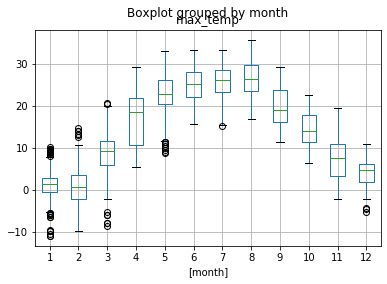

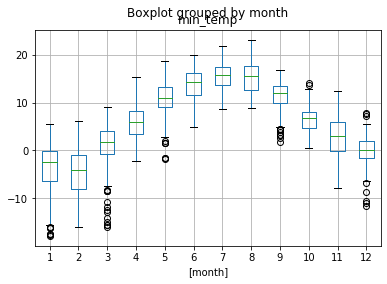

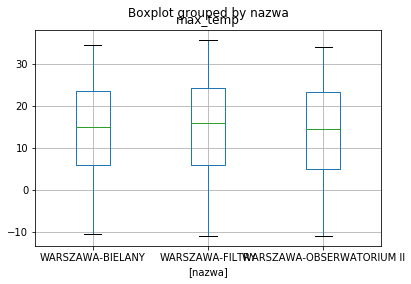

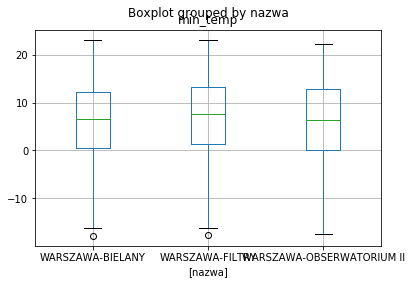

In [48]:
for c in ['max_temp','min_temp']:
    boxplot = df_imgw.boxplot(column=c,by=['month'])

for c in ['max_temp','min_temp']:
    boxplot = df_imgw.boxplot(column=c,by=['nazwa'])